In [ ]:
!pip install kagglehub version==0.3.13

ERROR: Could not find a version that satisfies the requirement version==0.3.13 (from versions: 0.1.0, 0.1.1)
ERROR: No matching distribution found for version==0.3.13


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone


# Required Imports

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from PIL import Image, UnidentifiedImageError

# Dataset Path

#Load Dataset and Detect Corrupted Images

In [ ]:
data_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Load DataFrame and Detect Corrupted Images

In [ ]:
filepath = []
labels = []
corrupted_images = []

for fold in os.listdir(data_dir):
    fold_path = os.path.join(data_dir, fold)
    for f in os.listdir(fold_path):
        file_path = os.path.join(fold_path, f)
        try:
            img = Image.open(file_path)
            img.verify()
            filepath.append(file_path)
            labels.append(fold)
        except (UnidentifiedImageError, OSError):
            corrupted_images.append(file_path)

print(f"🛠️ Corrupted images detected: {len(corrupted_images)}")

df = pd.DataFrame({'filepath': filepath, 'labels': labels})

🛠️ Corrupted images detected: 0


# Total Number of Images

In [ ]:
print(f"\n📷 Total valid images: {len(df)}")


📷 Total valid images: 12446


# Class Distribution


📈 Class Distribution (%):
labels
Normal    40.79
Cyst      29.80
Tumor     18.34
Stone     11.06
Name: proportion, dtype: float64


/tmp/ipython-input-1756781456.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', palette='viridis', order=df['labels'].value_counts().index)


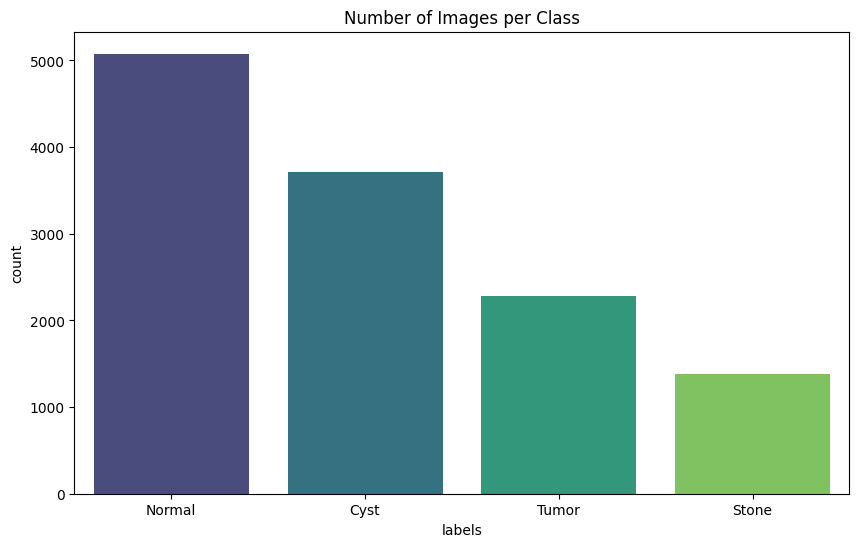

In [ ]:
class_dist = df['labels'].value_counts(normalize=True) * 100
print("\n📈 Class Distribution (%):")
print(class_dist.round(2))

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='labels', palette='viridis', order=df['labels'].value_counts().index)
plt.title('Number of Images per Class')
plt.show()

# Display Sample Images

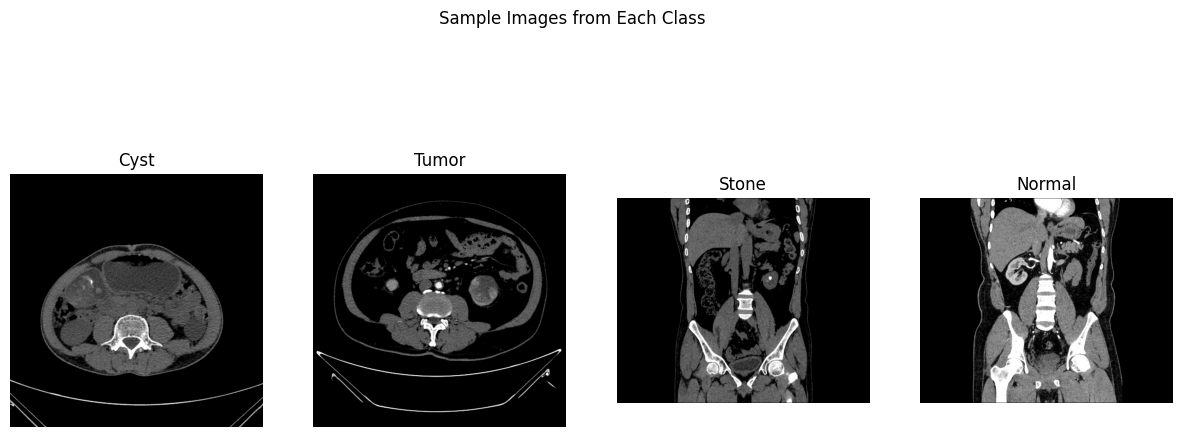

In [ ]:
def show_sample_images(df, n=5):
    plt.figure(figsize=(15, 6))
    for i, label in enumerate(df['labels'].unique()):
        sample = df[df['labels'] == label].sample(n=1).iloc[0]
        img = cv2.imread(sample['filepath'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(df['labels'].unique()), i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.suptitle("Sample Images from Each Class")
    plt.show()

show_sample_images(df)

# Train/Test Split

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
CLASSES = df['labels'].unique()

# Data Generators

In [ ]:
train_aug = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1,
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)

train_gen = train_aug.flow_from_dataframe(train_df, x_col='filepath', y_col='labels',
                                          target_size=(IMG_SIZE, IMG_SIZE), class_mode='categorical',
                                          batch_size=BATCH_SIZE, shuffle=True, seed=SEED, subset='training')

val_gen = train_aug.flow_from_dataframe(train_df, x_col='filepath', y_col='labels',
                                        target_size=(IMG_SIZE, IMG_SIZE), class_mode='categorical',
                                        batch_size=BATCH_SIZE, shuffle=False, subset='validation')

test_aug = ImageDataGenerator(rescale=1./255)

test_gen = test_aug.flow_from_dataframe(test_df, x_col='filepath', y_col='labels',
                                        target_size=(IMG_SIZE, IMG_SIZE), class_mode='categorical',
                                        batch_size=BATCH_SIZE, shuffle=False)


Found 7965 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.
Found 2490 validated image filenames belonging to 4 classes.


# Model Builders

In [ ]:
# Model Builders
def build_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(CLASSES)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_transfer_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(len(CLASSES), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Callbacks

In [ ]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.2)
]

# Evaluation and Plotting

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], marker='o', label='Train Acc')
    plt.plot(epochs, history.history['val_accuracy'], marker='o', label='Val Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)  # Show all epoch numbers
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], marker='o', label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], marker='o', label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)  # Show all epoch numbers
    plt.legend()

    plt.show()



# Evaluation

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 146s 553ms/step - accuracy: 0.5636 - loss: 1.0780 - val_accuracy: 0.6595 - val_loss: 0.8550 - learning_rate: 1.0000e-04
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 130s 522ms/step - accuracy: 0.6750 - loss: 0.8392 - val_accuracy: 0.6861 - val_loss: 0.7730 - learning_rate: 1.0000e-04
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 130s 521ms/step - accuracy: 0.6897 - loss: 0.7780 - val_accuracy: 0.7197 - val_loss: 0.6980 - learning_rate: 1.0000e-04
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 130s 521ms/step - accuracy: 0.7324 - loss: 0.6879 - val_accuracy: 0.7604 - val_loss: 0.6344 - learning_rate: 1.0000e-04
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 130s 521ms/step - accuracy: 0.7413 - loss: 0.6426 - val_accuracy: 0.7780 - val_loss: 0.5831 - learning_rate: 1.0000e-04
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 130s 523ms/step - accuracy: 0.7624 - loss: 0.5947 - val_accuracy: 0.7885 - val_loss: 0.5574 - learning_rate: 1.0000e-04
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 

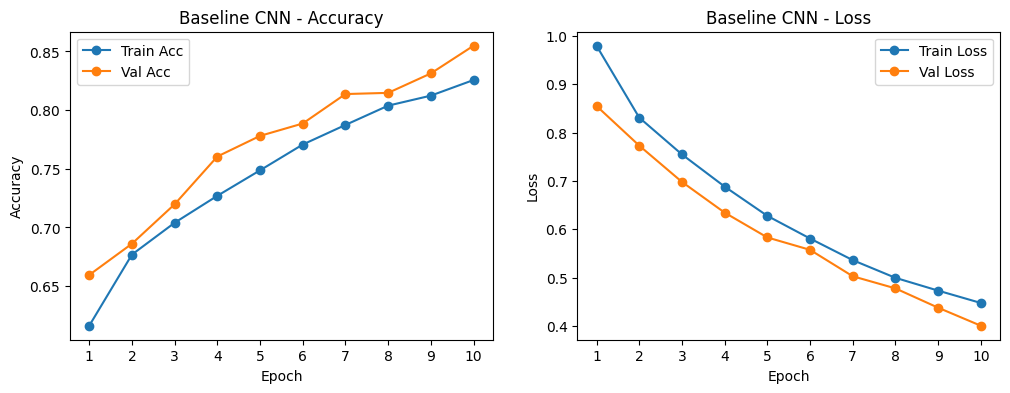


🧾 Baseline CNN Evaluation
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step
              precision    recall  f1-score   support

        Cyst       0.86      0.96      0.91       742
      Normal       0.93      0.86      0.89      1016
       Stone       0.78      0.64      0.71       275
       Tumor       0.78      0.86      0.82       457

    accuracy                           0.87      2490
   macro avg       0.84      0.83      0.83      2490
weighted avg       0.87      0.87      0.86      2490



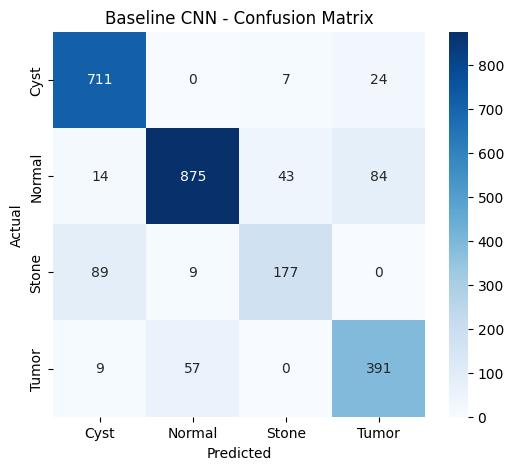

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.7475 - loss: 0.6763 - val_accuracy: 0.7966 - val_loss: 0.5649 - learning_rate: 1.0000e-04
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 131s 528ms/step - accuracy: 0.9790 - loss: 0.0617 - val_accuracy: 0.9422 - val_loss: 0.1580 - learning_rate: 1.0000e-04
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 132s 530ms/step - accuracy: 0.9879 - loss: 0.0403 - val_accuracy: 0.9879 - val_loss: 0.0331 - learning_rate: 1.0000e-04
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 132s 528ms/step - accuracy: 0.9930 - loss: 0.0212 - val_accuracy: 0.9990 - val_loss: 0.0072 - learning_rate: 1.0000e-04
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 131s 526ms/step - accuracy: 0.9967 - loss: 0.0124 - val_accuracy: 0.9965 - val_loss: 0.0082 - learning_rate: 1.0000e-04
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 132s 529ms/step - accuracy: 0.9953 - loss: 0.0163 - val_accuracy: 0.9945 - val_loss: 0.0197 - learning_rate: 1.0

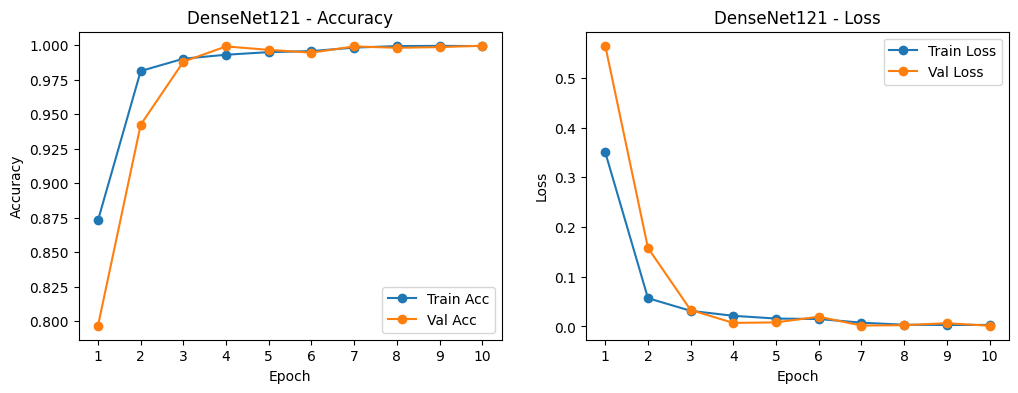


🧾 DenseNet121 Evaluation
78/78 ━━━━━━━━━━━━━━━━━━━━ 39s 342ms/step
              precision    recall  f1-score   support

        Cyst       0.99      1.00      1.00       742
      Normal       1.00      1.00      1.00      1016
       Stone       1.00      0.99      0.99       275
       Tumor       1.00      1.00      1.00       457

    accuracy                           1.00      2490
   macro avg       1.00      1.00      1.00      2490
weighted avg       1.00      1.00      1.00      2490



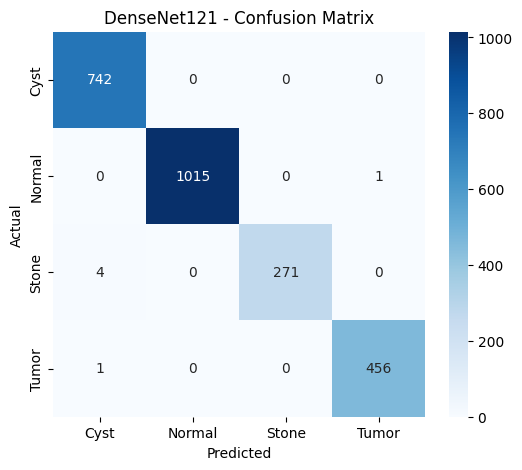

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 328s 907ms/step - accuracy: 0.6604 - loss: 0.8439 - val_accuracy: 0.1246 - val_loss: 1.4618 - learning_rate: 1.0000e-04
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 131s 525ms/step - accuracy: 0.9499 - loss: 0.1551 - val_accuracy: 0.1401 - val_loss: 1.7445 - learning_rate: 1.0000e-04
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 130s 523ms/step - accuracy: 0.9817 - loss: 0.0689 - val_accuracy: 0.1793 - val_loss: 1.8271 - learning_rate: 1.0000e-04
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 131s 525ms/step - accuracy: 0.9864 - loss: 0.0438 - val_accuracy: 0.4787 - val_loss: 1.4363 - learning_rate: 2.0000e-05
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 131s 527ms/step - accuracy: 0.9868 - loss: 0.0385 - val_accuracy: 0.1266 - val_loss: 1.6052 - learning_rate: 2.0000e-05
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 129s 520ms/step - accuracy: 0.9944 - loss: 0.0207 - val_accuracy: 0.5495 - val_loss: 1.0153 - learning_rate: 

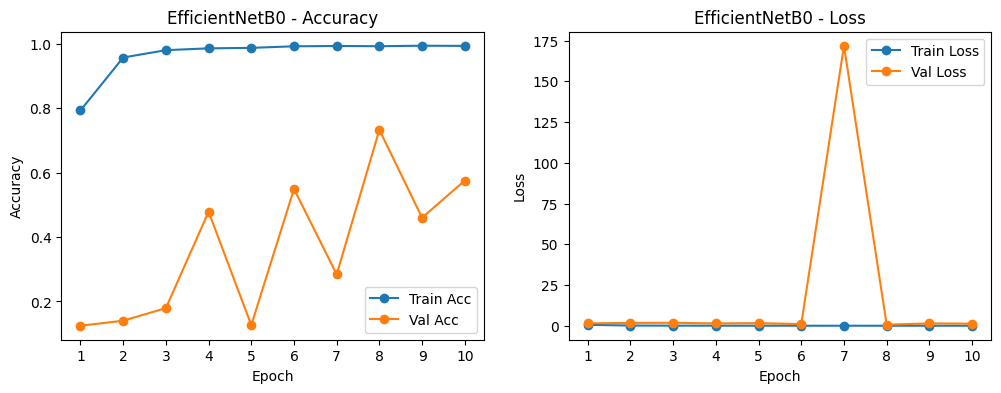


🧾 EfficientNetB0 Evaluation
78/78 ━━━━━━━━━━━━━━━━━━━━ 38s 407ms/step
              precision    recall  f1-score   support

        Cyst       0.96      0.82      0.88       742
      Normal       0.87      0.98      0.92      1016
       Stone       0.70      0.96      0.81       275
       Tumor       0.95      0.70      0.81       457

    accuracy                           0.88      2490
   macro avg       0.87      0.86      0.86      2490
weighted avg       0.89      0.88      0.88      2490



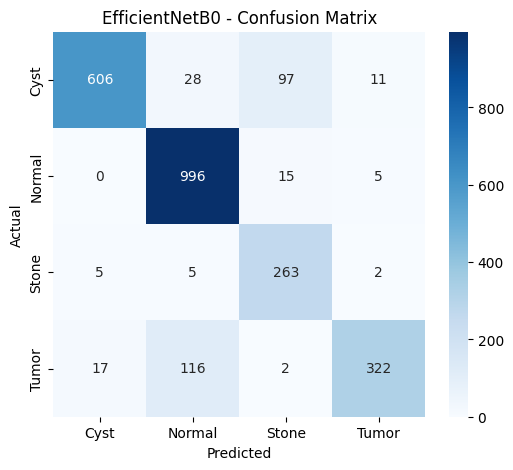

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 220s 663ms/step - accuracy: 0.7787 - loss: 0.5718 - val_accuracy: 0.4284 - val_loss: 1.3863 - learning_rate: 1.0000e-04
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 130s 522ms/step - accuracy: 0.9753 - loss: 0.0711 - val_accuracy: 0.2280 - val_loss: 1.7614 - learning_rate: 1.0000e-04
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 130s 521ms/step - accuracy: 0.9818 - loss: 0.0552 - val_accuracy: 0.1251 - val_loss: 4.8211 - learning_rate: 1.0000e-04
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 131s 524ms/step - accuracy: 0.9961 - loss: 0.0132 - val_accuracy: 0.3722 - val_loss: 2.4878 - learning_rate: 2.0000e-05


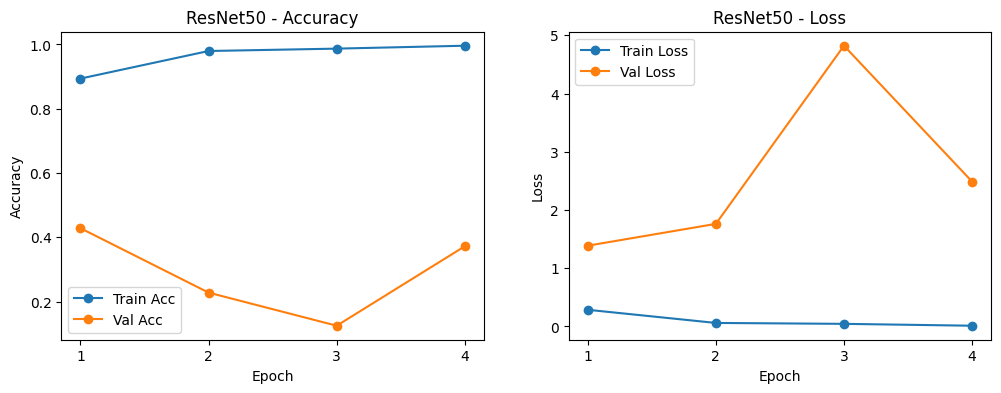


🧾 ResNet50 Evaluation
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step
              precision    recall  f1-score   support

        Cyst       1.00      0.02      0.04       742
      Normal       0.41      1.00      0.58      1016
       Stone       0.00      0.00      0.00       275
       Tumor       0.00      0.00      0.00       457

    accuracy                           0.41      2490
   macro avg       0.35      0.26      0.16      2490
weighted avg       0.47      0.41      0.25      2490



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


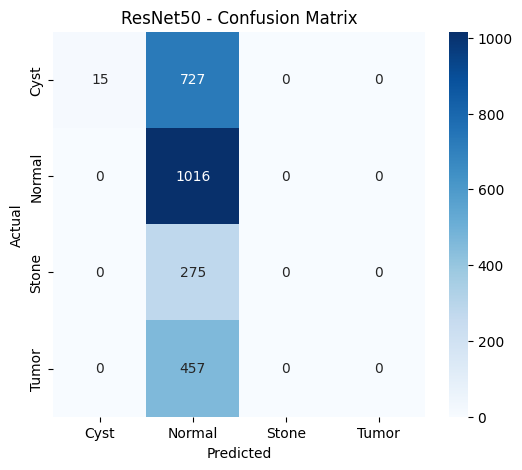

In [ ]:

def evaluate_model(model, model_name):
    print(f"\n🧾 {model_name} Evaluation")
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes
    labels = list(test_gen.class_indices.keys())

    print(classification_report(y_true, y_pred, target_names=labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()

# ▶️ Train & Evaluate All Models

# Baseline CNN
baseline_model = build_baseline_cnn()
history = baseline_model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)
plot_history(history, "Baseline CNN")
evaluate_model(baseline_model, "Baseline CNN")

# DenseNet121
base_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_densenet = build_transfer_model(base_densenet)
history = model_densenet.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)
plot_history(history, "DenseNet121")
evaluate_model(model_densenet, "DenseNet121")

# EfficientNetB0
base_efficient = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_efficient = build_transfer_model(base_efficient)
history = model_efficient.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)
plot_history(history, "EfficientNetB0")
evaluate_model(model_efficient, "EfficientNetB0")

# ResNet50
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_resnet = build_transfer_model(base_resnet)
history = model_resnet.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)
plot_history(history, "ResNet50")
evaluate_model(model_resnet, "ResNet50")